# 5. Focusing on a Single Cluster with same number of Coloumns

Here, we use Fuzzy Match to get similarity scores of the coloumn names for each of the Tables <br>
Ref -> https://www.datacamp.com/community/tutorials/fuzzy-string-python



In [1]:
import pandas as pd
from fuzzywuzzy import fuzz
import numpy as np
import math
import os

C:\Anaconda\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df_coloumns_names = pd.read_csv("F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/Demo ubc csvs Matadata/coloumn_Names_UBC_Baseline.csv")
# df_coloumns_names.head(5)

In [3]:
df_shape_topics = pd.read_csv("F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/Demo ubc csvs Matadata/Dominant_Topic_Coloumns_Shape_CSV.csv")
# df_shape_topics.head(5)

The fuzz.token functions have an important advantage over ratio and partial_ratio. They tokenize the strings and preprocess them by turning them to lower case and getting rid of punctuation. In the case of fuzz.token_sort_ratio(), the string tokens get sorted alphabetically and then joined together. After that, a simple fuzz.ratio() is applied to obtain the similarity percentage. This allows cases such as court cases in this example to be marked as being the same.

Still, what happens if these two strings are of widely differing lengths? Thats where fuzz.token_set_ratio() comes in.

In [4]:
def Two_Table_Raw_Similarity_Score(df1, df2, number_of_col):
    Col_Names = []
    Raw_Score = []
    for i in range(0,number_of_col):
        Col_Name = ('Col '+str(i+1))
        Str1 = df1.iloc[0][Col_Name]
        Str2 = df2.iloc[0][Col_Name]
        Partial_Ratio = fuzz.partial_ratio(Str1.lower(),Str2.lower())
        Raw_Score.append(Partial_Ratio)
        #Token_Set_Ratio = fuzz.token_set_ratio(Str1,Str2)
        #Raw_Score.append(Token_Set_Ratio)
    
    return(Raw_Score)    
        
def RMS_Similarity_Score(Raw_Scores_Array):
    Sum_Sq_Errors = 0
    for score in Raw_Scores_Array:
        Sum_Sq_Errors = Sum_Sq_Errors + math.pow((100-score),2)
    rms = math.sqrt(Sum_Sq_Errors)
    return(rms)
        

In [5]:
path = "F:/D&IMBU/DataScience/2019.10.07 - Environmental Baseline Team Project/Demo Deliverables/Demo ubc csvs"
os.chdir(path + " Matadata")


## This is actually giving out a N*N Matrix of the Similarity scores between the tables
def Matrix_RMS_Similarity_Score(df_shape_topics, df_coloumns_names, Topic, Col_Numbers):
    # Here we choose Tables with Coloumn_Numbers = 4 and Dominant_Topic = 1
    Focused_file = df_shape_topics.loc[(df_shape_topics.Coloumn_Numbers == Col_Numbers) & (df_shape_topics.Dominant_Topic == Topic)]['Link']
    Focused_file_list = Focused_file.tolist()
    
    Focused_df = df_coloumns_names[df_coloumns_names['Link'].isin(Focused_file_list)]
    Focused_df
    
    Focused_df = Focused_df.merge(df_shape_topics,
                              on = 'Link',
                              how = 'left',
                              indicator = True
                             )
    
    Focused_df.to_csv('Focused_DF_Baseline.csv')
    
    Focused_FileName = df_shape_topics.loc[(df_shape_topics.Coloumn_Numbers == Col_Numbers) & (df_shape_topics.Dominant_Topic == Topic)]['File_Name']
    Focused_FileName_list = Focused_FileName.tolist()
    
    Number_of_tables = len(Focused_df['Link'])
    
    RMS_Scores = []
    Mean_Scores = []
    for i in range(0,Number_of_tables):
        RMS_Score = []
        Mean_Score = []
        for j in range(0,Number_of_tables):
            df1 = Focused_df[Focused_df.Link == Focused_file_list[i]]
            df2 = Focused_df[Focused_df.Link == Focused_file_list[j]]
            Raw_Scores = Two_Table_Raw_Similarity_Score(df1, df2, Col_Numbers)
            Mean_Score.append(np.mean(Raw_Scores))
            RMS_Score.append(RMS_Similarity_Score(Raw_Scores))
        RMS_Scores.append(RMS_Score)
        Mean_Scores.append(Mean_Score)
    
    return Mean_Scores, RMS_Scores, Focused_FileName_list 



# Generating Heat Maps for Mean and RMS values of Similarity Scores

Ref -> https://stackoverflow.com/questions/39409866/correlation-heatmap  <br>
Ref2 -> https://stackoverflow.com/questions/39409866/correlation-heatmap <br> 
Ref3 -> https://seaborn.pydata.org/generated/seaborn.heatmap.html <br>
Colour Options:Ref4 -> https://python-graph-gallery.com/92-control-color-in-seaborn-heatmaps/

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def Plot_RMS_Heatmap(RMS_Scores, File_Names, Topic):
    ax = plt.axes()
    mask = np.zeros_like(RMS_Scores)
    mask = np.zeros_like(RMS_Scores)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(RMS_Scores, 
                cmap = "YlGnBu",
                annot = True,
                mask = mask,
                square = True,
                xticklabels = File_Names,
                yticklabels = File_Names)
    ax.set_title('Heatmap of RMS Scores for CSV tables of Dom. Topic {}'.format(Topic))
    
    
def Plot_Maen_Heatmap(Mean_Scores, File_Names, Topic):
    ax = plt.axes()
    mask = np.zeros_like(RMS_Scores)
    mask = np.zeros_like(RMS_Scores)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(Mean_Scores, 
                cmap = "Greens",
                annot = True,
                mask = mask,
                square = True,
                xticklabels = File_Names,
                yticklabels = File_Names)
    ax.set_title('Heatmap of Mean Scores for CSV tables of Dom. Topic {}'.format(Topic))
    

### Topic = 3 and ColNo = 2

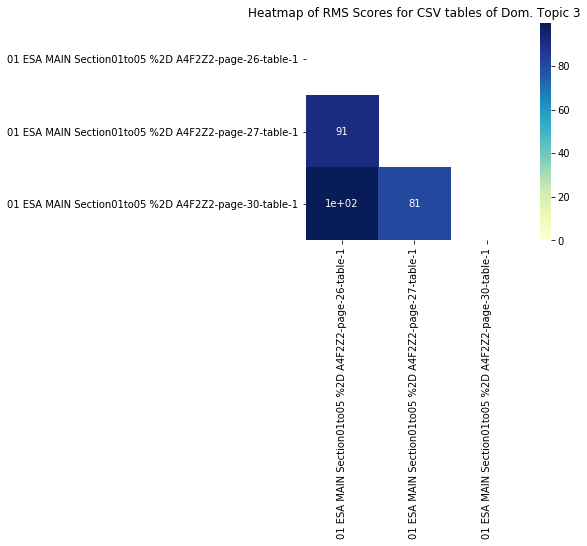

In [7]:

# A list with your data slightly edited
Topic = 3
Col_Numbers = 2
Mean_Scores, RMS_Scores, File_Names = Matrix_RMS_Similarity_Score(df_shape_topics, df_coloumns_names, Topic, Col_Numbers)


Plot_RMS_Heatmap(RMS_Scores, File_Names, Topic)

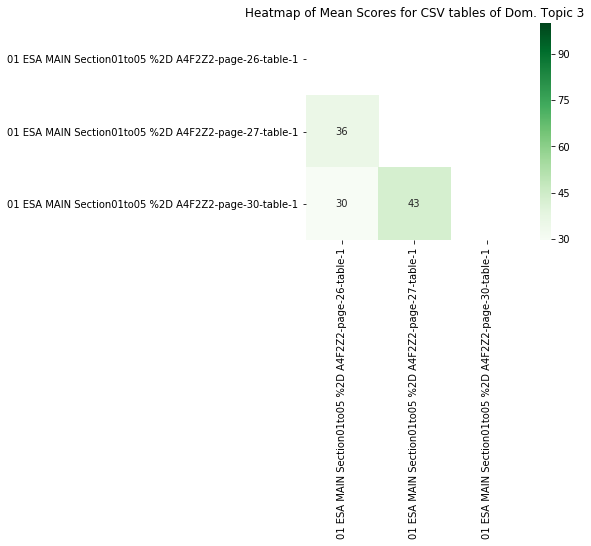

In [8]:
Plot_Maen_Heatmap(Mean_Scores, File_Names, Topic)

### Topic = 1 and ColNo = 4

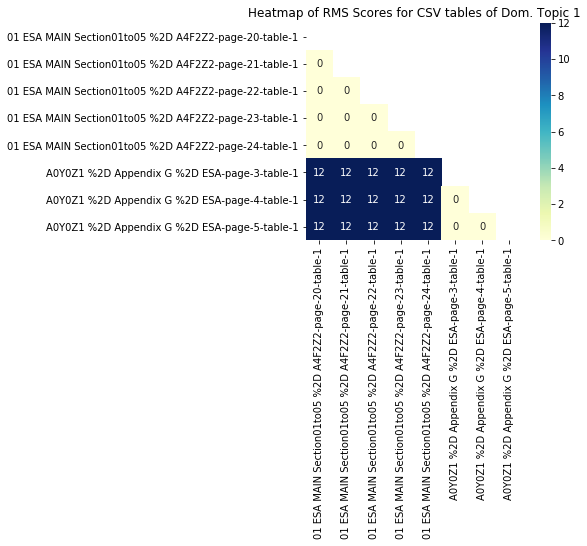

In [9]:
# A list with your data slightly edited
Topic = 1
Col_Numbers = 4
Mean_Scores, RMS_Scores, File_Names = Matrix_RMS_Similarity_Score(df_shape_topics, df_coloumns_names, Topic, Col_Numbers)


Plot_RMS_Heatmap(RMS_Scores, File_Names, Topic)

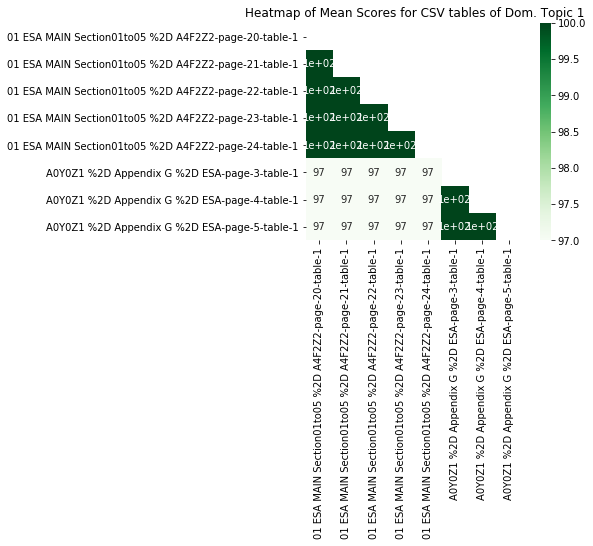

In [10]:
Plot_Maen_Heatmap(Mean_Scores,File_Names, Topic)